# Bike Sharing Usage Data Analysis

## Background
Bike sharing systems have gained popularity as a convenient and eco-friendly mode of transportation. These systems enable users to rent bikes from one location and return them to another. With over 500 bike-sharing programs worldwide, these systems play a significant role in traffic management, environmental sustainability, and public health.

The data generated by bike sharing systems is valuable for research purposes. Unlike other transport services, bike sharing systems record detailed information such as travel duration, departure, and arrival positions. This rich dataset can be used to analyze mobility patterns and detect important events in the city.

## Data Set
The core dataset used for this analysis is the two-year historical log from the Capital Bikeshare system in Washington D.C., USA. The dataset covers the years 2011 and 2012 and includes information on bike rentals aggregated on an hourly and daily basis. Additional weather and seasonal information is also incorporated into the dataset.

The data is publicly available from the Capital Bikeshare system website and weather information is sourced from http://www.freemeteo.com.

## Associated Tasks
This dataset lends itself to various analytical tasks, including:

- Regression: Predicting the number of bike rentals on an hourly or daily basis based on environmental and seasonal factors.
- Event and Anomaly Detection: The count of rented bikes can be correlated to specific events in the city. These events can be detected using search engine queries or external sources. Analyzing the dataset can validate anomaly detection algorithms or event detection methods.

## Files
The dataset includes the following files:

- Readme.txt
- hour.csv: Aggregated bike sharing counts on an hourly basis (17379 records)
- day.csv: Aggregated bike sharing counts on a daily basis (731 records)

## Dataset Characteristics
Both `hour.csv` and `day.csv` have the following fields, except for `hr` which is not available in `day.csv`:

- instant: Record index
- dteday: Date
- season: Season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: Year (0:2011, 1:2012)
- mnth: Month (1 to 12)
- hr: Hour (0 to 23)
- holiday: Indicates if the day is a holiday or not
- weekday: Day of the week
- workingday: Indicates if the day is a working day (neither weekend nor holiday)
- weathersit:
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Normalized temperature in Celsius (divided by 41, maximum value)
- atemp: Normalized feeling temperature in Celsius (divided by 50, maximum value)
- hum: Normalized humidity (divided by 100, maximum value)
- windspeed: Normalized wind speed (divided by 67, maximum value)
- casual: Count of casual users
- registered: Count of registered users
- cnt: Total count of rental bikes (including both casual and registered users)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
import statsmodels.stats.api as sms
import scipy.stats as stats
import copy
import pylab

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import f_oneway
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
df_day = pd.read_csv('../data/day.csv')

In [4]:
df_day.shape

(731, 16)

In [5]:
df = pd.read_csv('../data/hour.csv')

In [6]:
df.shape

(17379, 17)

> We will decide to continue with the hour dataset since it has more data than day.

In [7]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
df.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


# Data Pre-Processing

## Drop unneeded columns

In [9]:
df = df.drop(['instant', 'dteday'], axis=1)

> Instant column is an index of the column for the registration index. Will drop the column because it is not needed and will use the same index for all the other columns.

> The "date" or "dteday" column represents the specific date of each record in the bike sharing dataset. It is common to drop this column in certain analyses or modeling tasks for the following reasons:

> Redundancy: The "date" column contains information that is already represented by other columns such as year, month, and day of the week. Including the "date" column can introduce redundancy and increase the complexity of the analysis without providing any additional meaningful information.

> Non-Numeric Format: The "date" column is typically represented as a non-numeric format (e.g., yyyy-mm-dd), which may not be suitable for certain statistical or machine learning models that require numeric inputs. Removing the "date" column simplifies the dataset by keeping only the relevant numeric features.

> Temporal Dependencies: In some cases, time series analysis or forecasting tasks may involve considering the temporal dependencies between data points. However, for many other analysis tasks, the specific dates themselves may not be relevant. Removing the "date" column allows us to focus on the other important variables that affect bike rental behaviors.

In [10]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [11]:
df.shape

(17379, 15)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


> The provided information shows the first few rows of the dataset and its shape. The dataset has 17379 rows and 15 columns. Each column represents a specific attribute or feature, such as season, year, month, hour, holiday, weekday, workingday, weathersit, temperature, humidity, windspeed, and counts of casual, registered, and total rental bikes. The data types of the columns are mainly integers and floats.

## Fix data types
The variables season, yr, mnth, hr, holiday, weekday, workingday, and weathersit should be treated as categorical variables instead of integers. 

1. season: The values represent different seasons (1: spring, 2: summer, 3: fall, 4: winter). Even though the values are encoded as integers, they represent distinct categories rather than a continuous numerical scale.

2. yr: The values represent different years (0: 2011, 1: 2012). Similarly, the values indicate separate categories rather than a continuous numeric scale.

3. mnth: The values represent different months (1 to 12). While the values are represented by integers, they denote distinct categories rather than a continuous numerical sequence.

4. hr: The values represent different hours of the day (0 to 23). Although the values are represented as integers, they represent distinct time points rather than a continuous numeric scale.

5. holiday: The variable indicates whether the day is a holiday or not (0: not a holiday, 1: holiday). It is a binary categorical variable.

6. weekday: The values represent different days of the week (0: Sunday, 1: Monday, ..., 6: Saturday). Although the values are represented as integers, they correspond to distinct categories.

7. workingday: The variable indicates whether the day is a working day or not (0: not a working day, 1: working day). It is a binary categorical variable.

8. weathersit: The values represent different weather conditions (1: clear, 2: mist/cloudy, 3: light snow/rain, 4: heavy rain/snow). Although the values are encoded as integers, they represent distinct categories of weather conditions.

Treating these variables as categories instead of integers allows us to properly capture their qualitative nature and prevents any numerical assumptions or ordering that may be incorrect. By specifying them as categorical variables, we can perform appropriate statistical analysis and modeling techniques that consider the categorical nature of these variables.

In [13]:
# Assign certain columns as type category
df["season"] = df["season"].astype('category')
df["yr"] = df["yr"].astype('category')
df["mnth"] = df["mnth"].astype('category')
df["holiday"] = df["holiday"].astype('category')
df["weekday"] = df["weekday"].astype('category')
df["workingday"] = df["workingday"].astype('category')
df["weathersit"] = df["weathersit"].astype('category')

> Hour of the day has a natural ordering - 9am is closer to 10am or 8am than it is to 6pm. It is best thought of as a discrete ordinal variable. We will treat it as characteristic of being cyclic.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  int64   
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  casual      17379 non-null  int64   
 13  registered  17379 non-null  int64   
 14  cnt         17379 non-null  int64   
dtypes: category(7), float64(4), int64(4)
memory usage: 1.2 MB


## Check for missing values

In [15]:
df.isna().sum()   #null value check

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

> No missing values. We can proceed with further analysis, modeling, and interpretation of the dataset without concerns about missing values.

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


> Hour of the day (hr) ranges from 0 to 23, with a mean of 11.55. It indicates that the data covers a full 24-hour cycle, and the distribution of bike rentals throughout the day varies.

> Temperature (temp) and feeling temperature (atemp) are normalized variables ranging from 0 to 1. The mean temperature is around 0.5, indicating a moderate average temperature. The feeling temperature is slightly lower on average.

> Humidity (hum) is also a normalized variable ranging from 0 to 1. The mean humidity is 0.63, indicating a moderate level of humidity on average.

> Windspeed (windspeed) is a normalized variable ranging from 0 to 0.85. The mean windspeed is 0.19, suggesting a relatively calm wind environment.

> The count of casual users (casual) ranges from 0 to 367, with a mean of 35.68. The count of registered users (registered) ranges from 0 to 886, with a mean of 153.79. The total count of rental bikes (cnt) ranges from 1 to 977, with a mean of 189.46. These variables represent the target variable and indicate the number of bike rentals by different user types.

> This summary provide insights into the distribution and variability of the different variables in the dataset. We will further analyzed to understand patterns, trends, and relationships between the variables.

In [17]:
df = df.drop(['registered', 'casual', 'atemp'], axis=1)

> In the context of the given data, dropping the "atemp", "registered" and "casual" columns can help address multicollinearity concerns.

> By removing these columns, we eliminate potential redundancy or overlap in the information captured by the remaining variables. If the "registered" and "casual" columns are highly correlated with other variables in the dataset, keeping them in the analysis could introduce multicollinearity issues. This can result in unreliable coefficient estimates and inflated standard errors, making it challenging to draw accurate conclusions about the relationship between the remaining variables and the target variable.

> Dropping these columns can also improve the efficiency of the analysis by reducing the dimensionality of the dataset. With fewer variables, the model becomes simpler and easier to interpret, allowing us to focus on the most relevant predictors.

> We will drop 'registered', 'casual', and 'atemp' for the following reasons:

> 'registered': This column represents the count of registered users. Since the goal is to predict the total count of rental bikes (cnt), including both casual and registered users, keeping the 'registered' column could lead to data leakage. Data leakage occurs when information from the target variable or future data is unintentionally used during the model training process, which can result in overly optimistic performance metrics. Therefore, it is common practice to exclude this column when predicting the total count.

> 'casual': Similar to the 'registered' column, the 'casual' column represents the count of casual users. It is also dropped for the same reasons mentioned above.

> 'atemp': This column represents the normalized feeling temperature. It is being dropped because it is highly correlated with the 'temp' column, which represents the normalized temperature. Including highly correlated variables in the model can lead to multicollinearity issues, where the predictors become redundant and can negatively affect the model's performance and interpretability. Therefore, one of the correlated variables is often dropped to avoid such issues, and in this case, 'atemp' is chosen to be dropped.

> By dropping these columns, the DataFrame is simplified and optimized for further analysis and modeling without the risk of data leakage or multicollinearity.

## One-hot encoding to convert categorical variables into binary vectors

In [18]:
df_enc = pd.get_dummies(df, columns = ['season', 'weathersit'])
df_enc.head()

,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,1,0,0,6,0,0.24,0.81,0.0,16,1,0,0,0,1,0,0,0
1,0,1,1,0,6,0,0.22,0.80,0.0,40,1,0,0,0,1,0,0,0
2,0,1,2,0,6,0,0.22,0.80,0.0,32,1,0,0,0,1,0,0,0
3,0,1,3,0,6,0,0.24,0.75,0.0,13,1,0,0,0,1,0,0,0
4,0,1,4,0,6,0,0.24,0.75,0.0,1,1,0,0,0,1,0,0,0


In [19]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   yr            17379 non-null  category
 1   mnth          17379 non-null  category
 2   hr            17379 non-null  int64   
 3   holiday       17379 non-null  category
 4   weekday       17379 non-null  category
 5   workingday    17379 non-null  category
 6   temp          17379 non-null  float64 
 7   hum           17379 non-null  float64 
 8   windspeed     17379 non-null  float64 
 9   cnt           17379 non-null  int64   
 10  season_1      17379 non-null  uint8   
 11  season_2      17379 non-null  uint8   
 12  season_3      17379 non-null  uint8   
 13  season_4      17379 non-null  uint8   
 14  weathersit_1  17379 non-null  uint8   
 15  weathersit_2  17379 non-null  uint8   
 16  weathersit_3  17379 non-null  uint8   
 17  weathersit_4  17379 non-null  uint8   
dtypes: cat

> The updated DataFrame has 18 columns. The categorical columns ('yr', 'mnth', 'holiday', 'weekday', 'workingday') have been converted to the category data type. The 'hr' column remains as an integer, while the 'temp', 'hum', 'windspeed', and 'cnt' columns retain their original data types. One-hot encoding created additional columns ('season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4') representing the categories in 'season' and 'weathersit'. The memory usage has reduced to 900.7 KB.

# Exploratory Data Analysis

## Univariate Analysis

### Correlation matrix of all columns

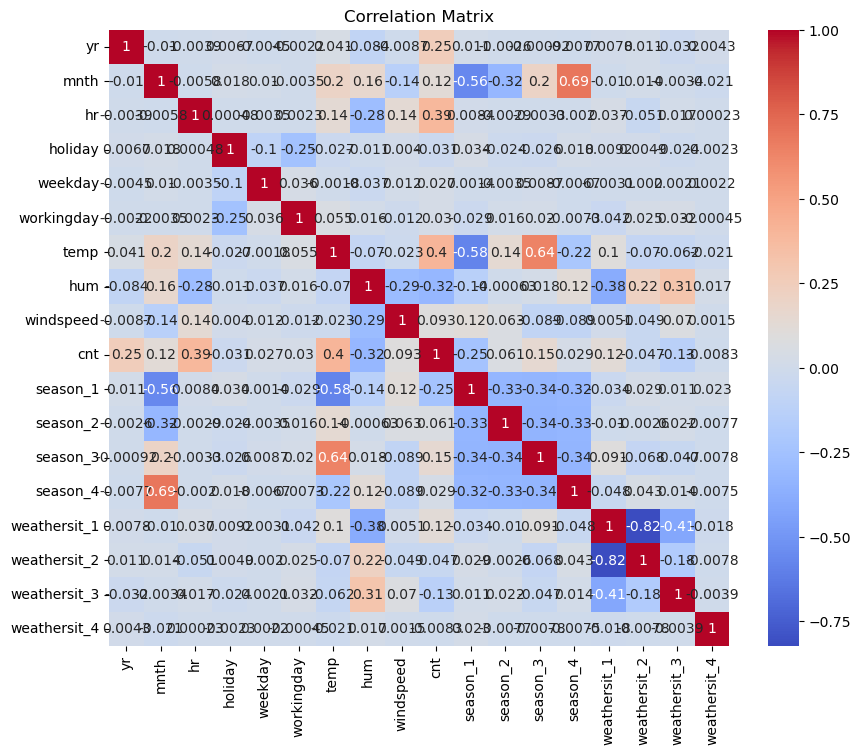

In [20]:
# Compute the correlation matrix
correlation_matrix = df_enc.corr(numeric_only=False)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

> The highest correlation value in the given correlation matrix is 0.64, which corresponds to the correlation between variables 'season_3' and 'temp'. 

> The lowest correlation value in the given correlation matrix is -0.58, which corresponds to the correlation between variables 'season_1' and 'temp'.

## Scatterplots of count vs. 1 independent variable of significance

### Count vs. Hour

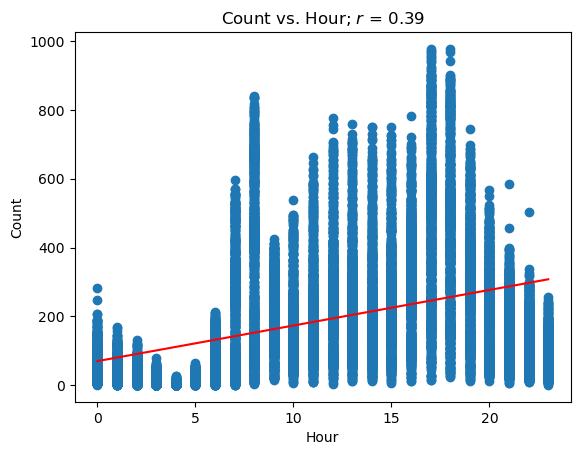

In [21]:
x = df_enc['hr'] 
y = df_enc['cnt']
plt.title('Count vs. Hour')
plt.xlabel('Hour')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs. Hour;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

> The scatter plot and correlation coefficient suggest a moderate positive correlation between the hour of the day and the count of bike rentals. The correlation coefficient of 0.39 indicates that there is a tendency for the bike count to increase as the hour of the day progresses, but the relationship is not extremely strong.

> It indicates that there may be certain peak hours where the bike count is higher compared to other hours. However, it's important to note that the scatter plot and correlation coefficient alone do not provide information about the direction or causality of the relationship.

### Count vs. Temperature

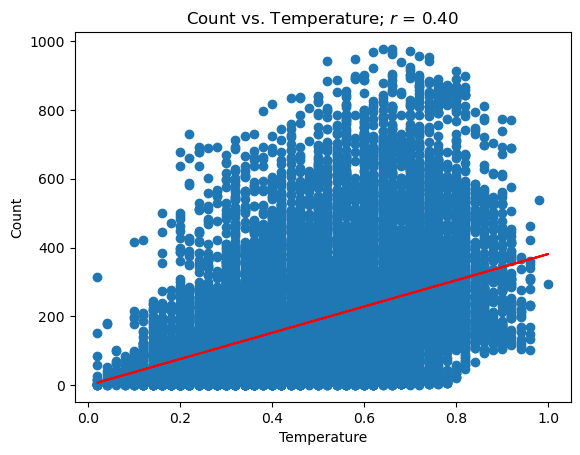

In [22]:
x = df_enc['temp'] 
y = df_enc['cnt']
plt.title('Count vs. Temperature')
plt.xlabel('Temperature')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs. Temperature;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

> The correlation coefficient between temperature and count is 0.4. This value indicates a moderate positive correlation between the two variables. It suggests that there is a tendency for the bike count to increase as the temperature increases, but the relationship is not extremely strong.

### Count vs. Humidity

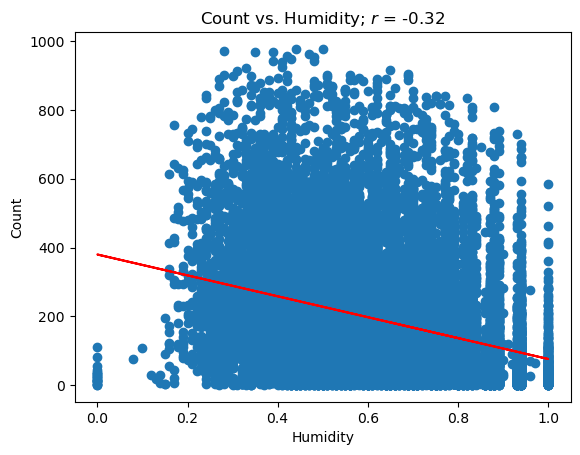

In [23]:
x = df_enc['hum'] 
y = df_enc['cnt']
plt.title('Count vs. Humidity')
plt.xlabel('Humidity')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs. Humidity;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

> It suggest a moderate negative correlation between humidity and the count of bike rentals. The correlation coefficient of -0.32 indicates that there is a tendency for the bike count to decrease as humidity levels increase, although the relationship is not extremely strong.

> The scatter plot shows the distribution of bike count values across different humidity levels. It suggests that there may be a trend where bike rentals are slightly lower during higher humidity conditions. Then again, it's important to note that the scatter plot and correlation coefficient alone do not provide information about the direction or causality of the relationship.

### Count vs. Windspeed

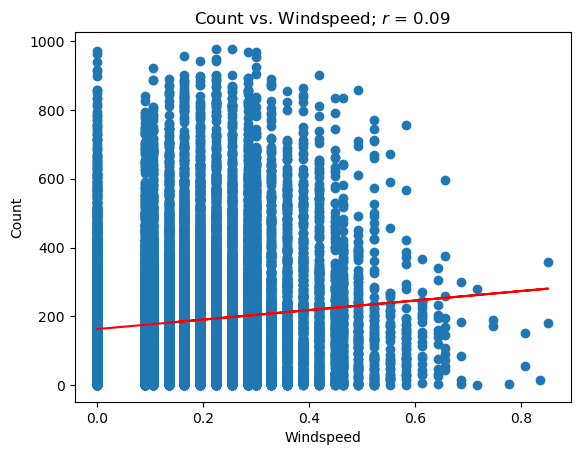

In [24]:
x = df_enc['windspeed'] 
y = df_enc['cnt']
plt.title('Count vs. Windspeed')
plt.xlabel('Windspeed')       
plt.ylabel('Count')           

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y) 
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Count vs. Windspeed;' ' $\mathit{r}$ = ' + "{:.2f}".format(corr))
plt.show()

> The correlation coefficient of 0.09 indicates a very weak relationship between these variables.

> The scatter plot shows the distribution of bike count values across different windspeed levels. There is no clear trend or pattern visible in the plot, which aligns with the weak correlation coefficient. This suggests that windspeed has minimal impact on the count of bike rentals.

## Analysis of each independent variable

### Analysis of year

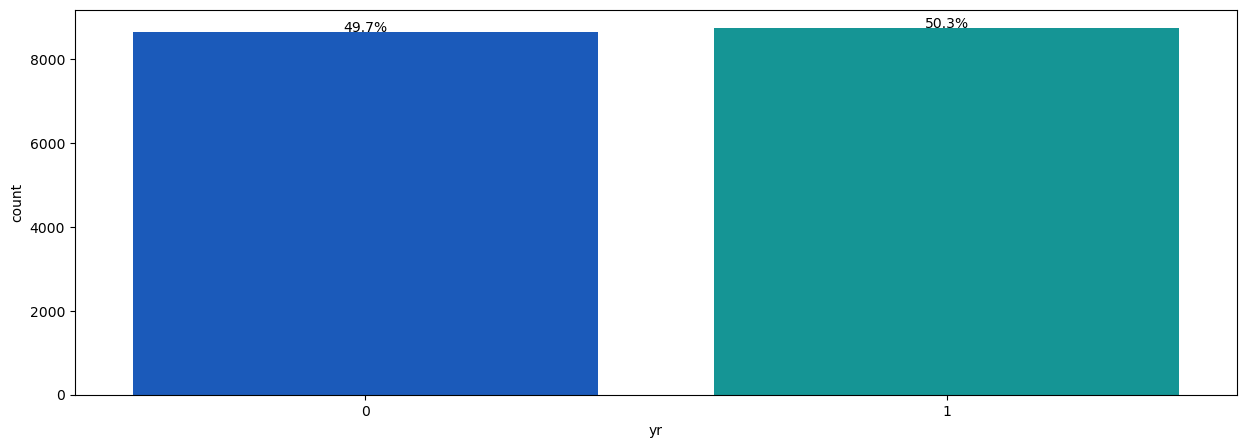

In [25]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="yr", palette='winter')
perc_on_bar(ax, df_enc["yr"])
plt.show()

> Year 0 = 2011, Year 1 = 2012. They both seem to be evenly distributed.

### Analysis of month

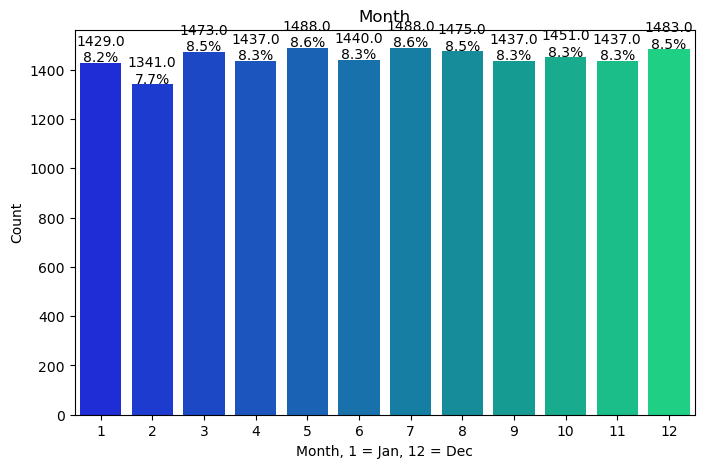

In [26]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="mnth", palette='winter')

total = len(df["mnth"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Month, 1 = Jan, 12 = Dec")
plt.ylabel("Count")
plt.title("Month")
plt.show()

> The variations in the count values suggest that there are seasonal patterns in bike rental usage.

> From the given count values, it appears that the months with higher counts are March, May, July, and August, while the months with lower counts are February, April, June, September, November, and December. This suggests that bike rentals tend to be more popular during the spring and summer months, possibly due to more favorable weather conditions.

> These observations can be useful for understanding the demand for bike rentals throughout the year and can assist in resource planning, marketing strategies, and operational decisions related to bike-sharing systems.

### Analysis of hour

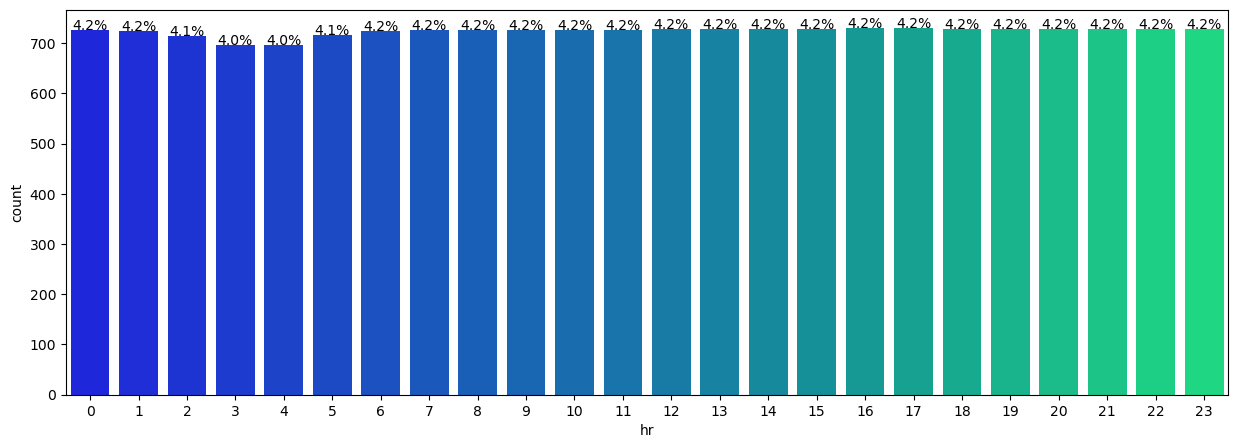

In [27]:
def perc_on_bar(ax, data):
    total = len(data)
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}', (x + width/2, y + height), ha='center')

plt.figure(figsize=(15, 5))
ax = sns.countplot(data=df_enc, x="hr", palette='winter')
perc_on_bar(ax, df_enc["hr"])
plt.show()

> The count values for each hour represent the number of bike rentals recorded during that specific hour of the day. 

> From the given count values, we can observe certain patterns in bike rental usage throughout the day. The counts are relatively low during the early morning hours (from 0 to 5), indicating fewer bike rentals during this time. As the morning progresses and reaches the peak commuting hours (around 7 to 9), the counts start to rise, suggesting increased bike rental activity as people start their day and commute to work or other activities.

> The counts remain relatively high during the daytime hours (from 9 to 17), indicating consistent bike rental demand throughout the day. However, there is a slight dip in counts during the late afternoon hours (around 16 to 18) before picking up again in the evening hours.

> Towards the late evening (from 19 to 23), the counts start to decrease gradually, indicating a decline in bike rental activity as people wind down their day and return home.

> These observations suggest that bike rental patterns are influenced by daily routines and commuting behaviors, with higher demand during peak commuting hours and relatively lower demand during early morning and late evening hours.

> Understanding the hourly variations in bike rental counts can be valuable for managing inventory, optimizing operations, and planning promotional activities to meet the demand during specific time periods throughout the day.

### Analysis of holiday

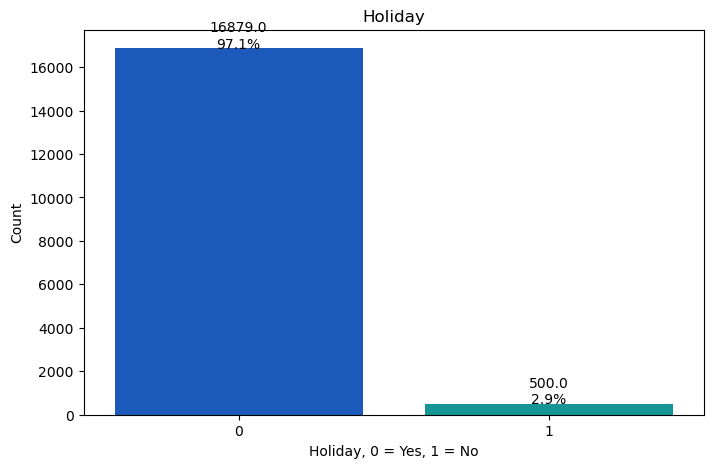

In [28]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="holiday", palette='winter')

total = len(df["holiday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Holiday, 0 = Yes, 1 = No")
plt.ylabel("Count")
plt.title("Holiday")
plt.show()

> From the given count values, we can see that the majority of the observations (16,879) correspond to non-holiday days, while a smaller number of observations (500) correspond to holiday days.

> This distribution suggests that bike rentals are more prevalent on non-holiday days compared to holidays. It is likely that on non-holiday days, people use bikes for various purposes such as commuting to work, running errands, or recreational activities. On the other hand, on holidays, people may engage in different types of activities or have alternative transportation options, leading to a lower demand for bike rentals.

> Understanding the difference in bike rental patterns between holiday and non-holiday days can be useful for resource planning and operational decisions. For example, during non-holiday periods, bike rental services may need to ensure an adequate supply of bikes and manage operations efficiently to meet the higher demand.

### Analysis of weekday

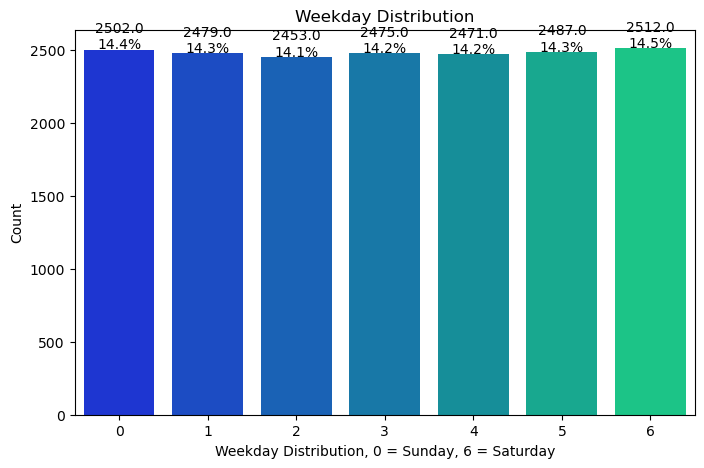

In [29]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="weekday", palette='winter')

total = len(df["weekday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Weekday Distribution, 0 = Sunday, 6 = Saturday")
plt.ylabel("Count")
plt.title("Weekday Distribution")
plt.show()

> This distribution suggests that bike rentals have a relatively consistent pattern throughout the weekdays, with slightly higher counts on weekends (Saturday and Sunday). The higher counts on weekends may be attributed to leisure activities, recreational biking, and individuals using bikes for weekend outings or events.

> This variation in bike rentals across weekdays is valuable for bike-sharing service providers. It helps them allocate resources, manage bike availability, and plan operational strategies more effectively. For example, they may consider increasing bike availability and optimizing customer support on weekends to meet the higher demand during those days.

### Analysis of workingday

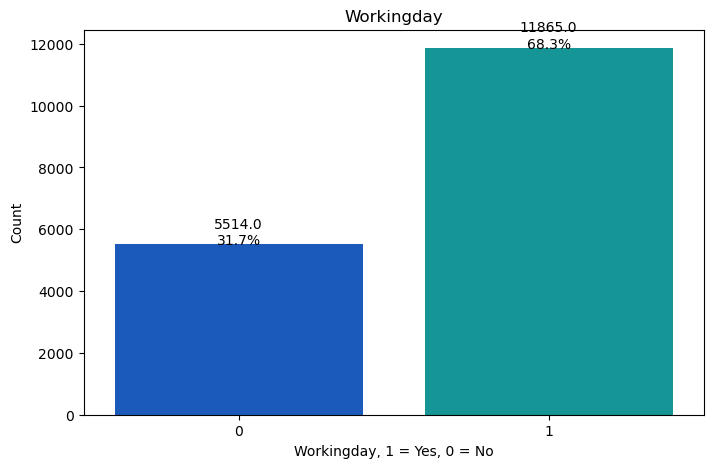

In [30]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_enc, x="workingday", palette='winter')

total = len(df["workingday"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Workingday, 1 = Yes, 0 = No")
plt.ylabel("Count")
plt.title("Workingday")
plt.show()

>This indicates that there are more bike rentals on working days compared to non-working days. It suggests that people tend to use bike-sharing services more frequently on working days, which could be attributed to commuting to work or other work-related activities.

> The higher count of bike rentals on working days can be attributed to the larger number of working days in the dataset. It is important to consider the proportion of working days to non-working days in the dataset when interpreting the count values. In this case, since there are more working days, it is expected to see a higher count of bike rentals on those days.

> This information can be valuable for bike-sharing service providers in terms of resource allocation and operational planning. They can focus their efforts on meeting the higher demand on working days, such as ensuring an adequate supply of bikes and optimizing their service availability during peak commuting hours.

### Analysis of weather situations

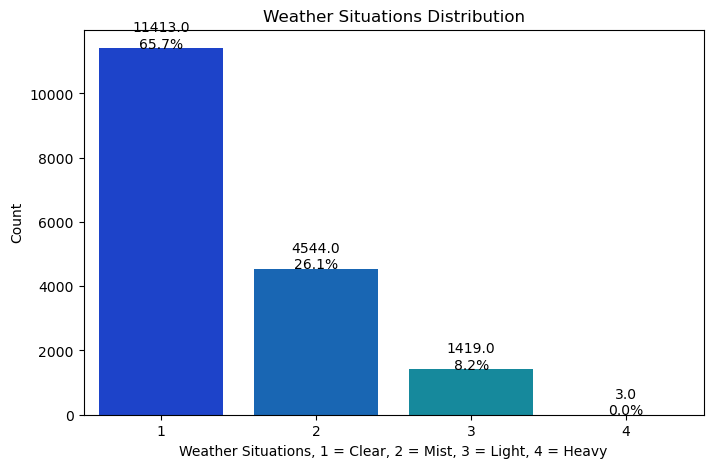

In [31]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="weathersit", palette='winter')

total = len(df["weathersit"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Weather Situations, 1 = Clear, 2 = Mist, 3 = Light, 4 = Heavy")
plt.ylabel("Count")
plt.title("Weather Situations Distribution")
plt.show()

> This indicates the distribution of bike rentals based on different weather situations.

> Weather situation 1: This category has the highest count, indicating that most bike rentals occur during clear or slightly cloudy weather conditions.

> Weather situation 2: This category has a relatively lower count compared to situation 1, suggesting that bike rentals are slightly lower during misty or cloudy weather conditions.

> Weather situation 3: This category has a lower count compared to situations 1 and 2, indicating that bike rentals decrease further during light snow or rain with scattered clouds.

> Weather situation 4: This category has the lowest count, with only 3 instances. This suggests that bike rentals are extremely rare during heavy rain, ice pellets, thunderstorms, mist, or fog.

> These observations suggest that weather conditions have an influence on bike rental patterns. People are more likely to rent bikes during favorable weather conditions (situation 1) and less likely to rent bikes during unfavorable or extreme weather conditions (situations 3 and 4). This information can be valuable for bike-sharing service providers in understanding the demand patterns based on weather and adjusting their operations and marketing strategies accordingly.

### Analysis of season

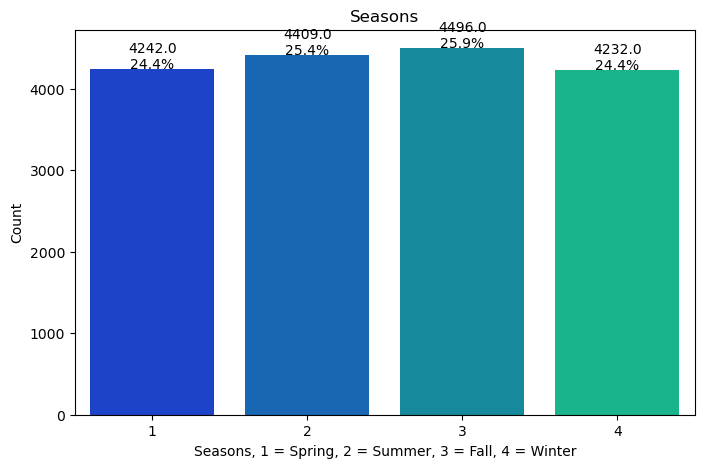

In [32]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="season", palette='winter')

total = len(df["season"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}\n{height/total:.1%}', ha='center')

plt.xlabel("Seasons, 1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter")
plt.ylabel("Count")
plt.title("Seasons")
plt.show()

> This distribution represents the number of bike rentals recorded during different seasons.

> Season 3 (fall) has the highest count, indicating that bike rentals are most popular during the fall season. This could be due to favorable weather conditions, such as mild temperatures and pleasant surroundings.

> Season 2 (summer) also has a relatively high count, suggesting that bike rentals are popular during the summer months when the weather is warm and people engage in outdoor activities.

> Season 4 (winter) has a slightly lower count compared to seasons 2 and 3, indicating that bike rentals decrease during the winter season, possibly due to colder temperatures and less favorable riding conditions.

> Season 1 (spring) has the lowest count, suggesting that bike rentals are relatively less popular during the spring season. This could be due to changing weather conditions and other factors.

> These observations highlight the seasonal variations in bike rental patterns. Bike rentals tend to be highest during the fall and summer seasons, while they decrease during the winter and spring seasons. Understanding these seasonal patterns can help bike-sharing service providers optimize their operations, marketing strategies, and resource allocation based on the anticipated demand during different seasons.

### Analysis of temperature

In [33]:
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """
    Boxplot and histogram combined.

    Parameters:
    - feature: 1-D feature array
    - figsize: size of the figure (default: (15, 10))
    - bins: number of bins for histogram (default: None/auto)

    Returns:
    - None
    """

    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    sns.boxplot(feature, ax=ax_box, showmeans=True, color='violet')

    if bins:
        sns.histplot(feature, kde=False, ax=ax_hist, bins=bins, palette="winter")
    else:
        sns.histplot(feature, kde=False, ax=ax_hist)

    ax_hist.axvline(np.mean(feature), color='green', linestyle='--')
    ax_hist.axvline(np.median(feature), color='black', linestyle='-')

    plt.show()

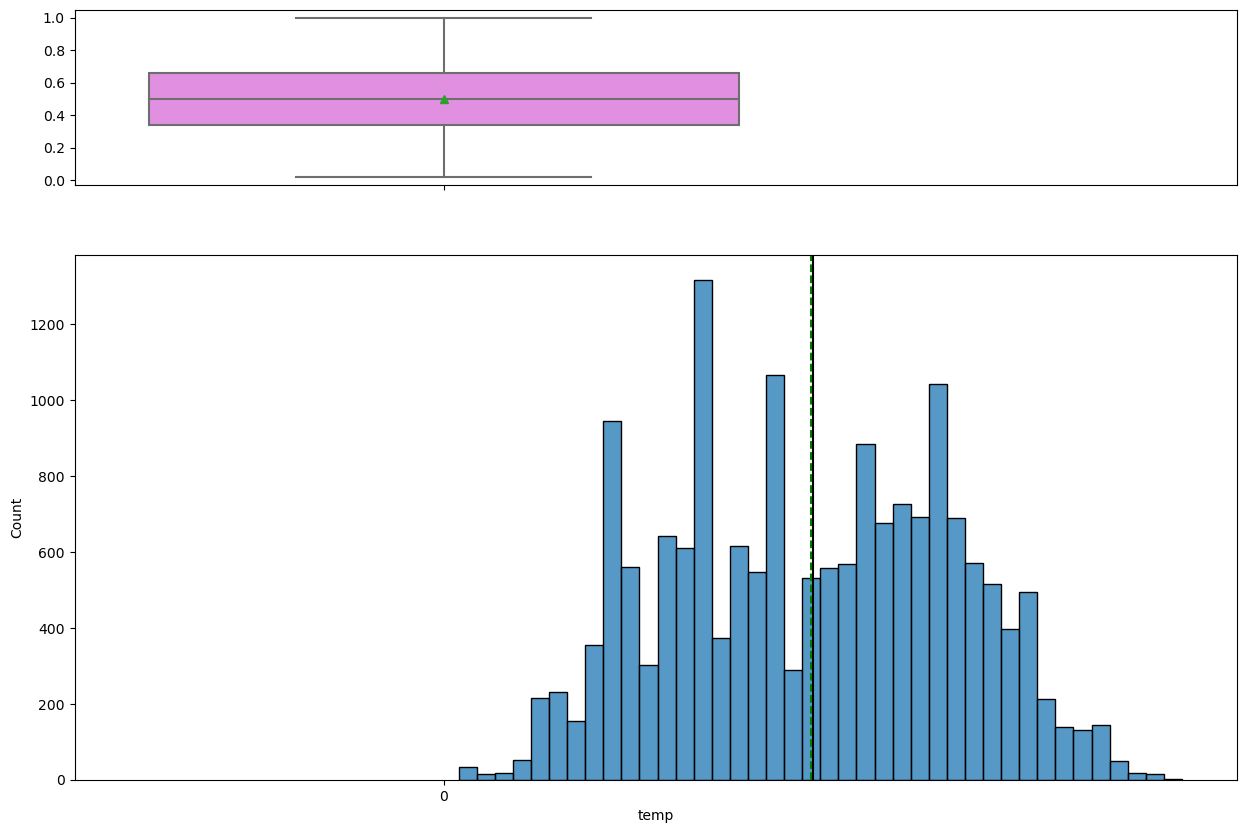

In [34]:
histogram_boxplot(df_enc["temp"])

> Mean: The average temperature is approximately 0.50.
Standard Deviation: The temperature values have a standard deviation of around 0.19.
Minimum and Maximum: The minimum temperature recorded is 0.02, and the maximum temperature recorded is 1.00.
Quartiles: The first quartile (25th percentile) is at 0.34, the median (50th percentile) is at 0.50, and the third quartile (75th percentile) is at 0.66.
From these observations, we can infer that the temperature values are normalized, ranging between 0 and 1. The distribution appears to be relatively symmetric, as the mean and median values are close. The standard deviation indicates moderate variability in the temperature values.

In [35]:
# Simple Linear Regression of count vs. temperature
X1 = df_enc['temp']
y = df_enc['cnt']

X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:55   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0356      3.483     -0.010      0.992      -6.862       6.791
temp         381.2949      6.534     58.352      0.000     368.487     394.103
==============================================================================
Omnibus:                     3140.760   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5634.907
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.572   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The R-squared value of 0.164 suggests that approximately 16.4% of the variation in the count can be explained by changes in temperature alone. This indicates a relatively weak relationship between temperature and count. The coefficient for 'temp' is 381.2949, suggesting that for every one-unit increase in temperature, the count is expected to increase by approximately 381. However, it's important to note that the constant term is not statistically significant, suggesting that there may be other factors not included in the model that influence the count. Overall

### Analysis of humidity

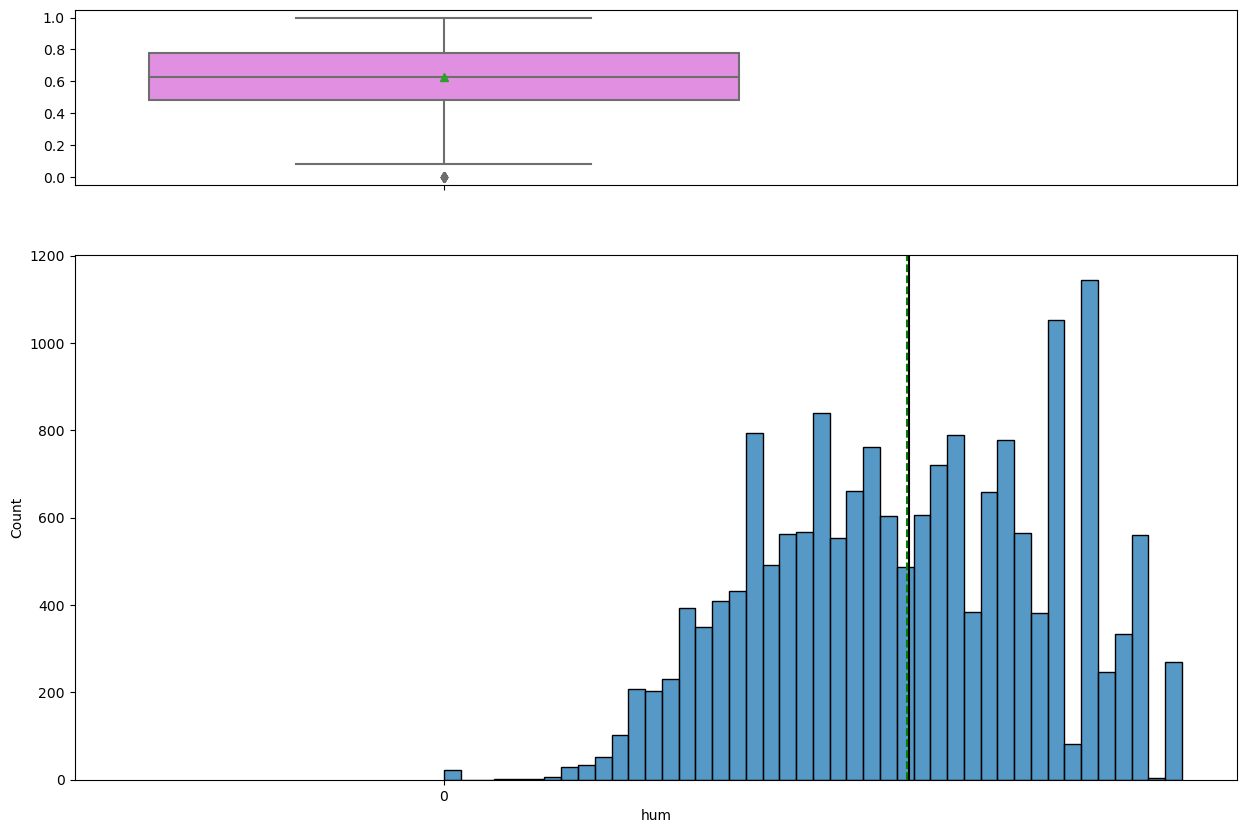

In [36]:
histogram_boxplot(df_enc["hum"])

> Mean: The average humidity is approximately 0.63.
Standard Deviation: The humidity values have a standard deviation of around 0.19.
Minimum and Maximum: The minimum humidity recorded is 0.00, and the maximum humidity recorded is 1.00.
Quartiles: The first quartile (25th percentile) is at 0.48, the median (50th percentile) is at 0.63, and the third quartile (75th percentile) is at 0.78.
From these observations, we can infer that the humidity values are also normalized, ranging between 0 and 1. The distribution appears to be relatively symmetric, as the mean and median values are close. The standard deviation indicates moderate variability in the humidity values.

In [37]:
# Simple linear regression of count vs. temperature
X1 = df_enc['hum']
y = df_enc['cnt']

import statsmodels.api as sm # use stats models for basic linear regression
X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2023.
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:55   Log-Likelihood:            -1.1408e+05
No. Observations:               17379   AIC:                         2.282e+05
Df Residuals:                   17377   BIC:                         2.282e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        379.8849      4.430     85.761      0.000     371.202     388.567
hum         -303.5923      6.750    -44.976      0.000    -316.823    -290.361
==============================================================================
Omnibus:                     3480.028   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6472.551
Skew:                           1.250   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         7.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The OLS regression results show that the model predicts the 'cnt' (count) variable using the 'hum' (humidity) variable. The R-squared value of 0.104 indicates that approximately 10.4% of the variation in count can be explained by changes in humidity alone. The coefficient for 'hum' is -303.5923, suggesting that for every one-unit increase in humidity, the count is expected to decrease by approximately 303. The constant term is statistically significant, with a coefficient of 379.8849, indicating that it has an independent effect on the count. The additional statistics, such as the F-statistic, AIC, BIC, Omnibus, Durbin-Watson, Jarque-Bera, skewness, and kurtosis, provide further insights into the model's performance and assumptions. Overall, the model suggests that humidity has a statistically significant impact on the count, but it only explains a relatively small portion of the total variation in the count.

## Observations on windspeed

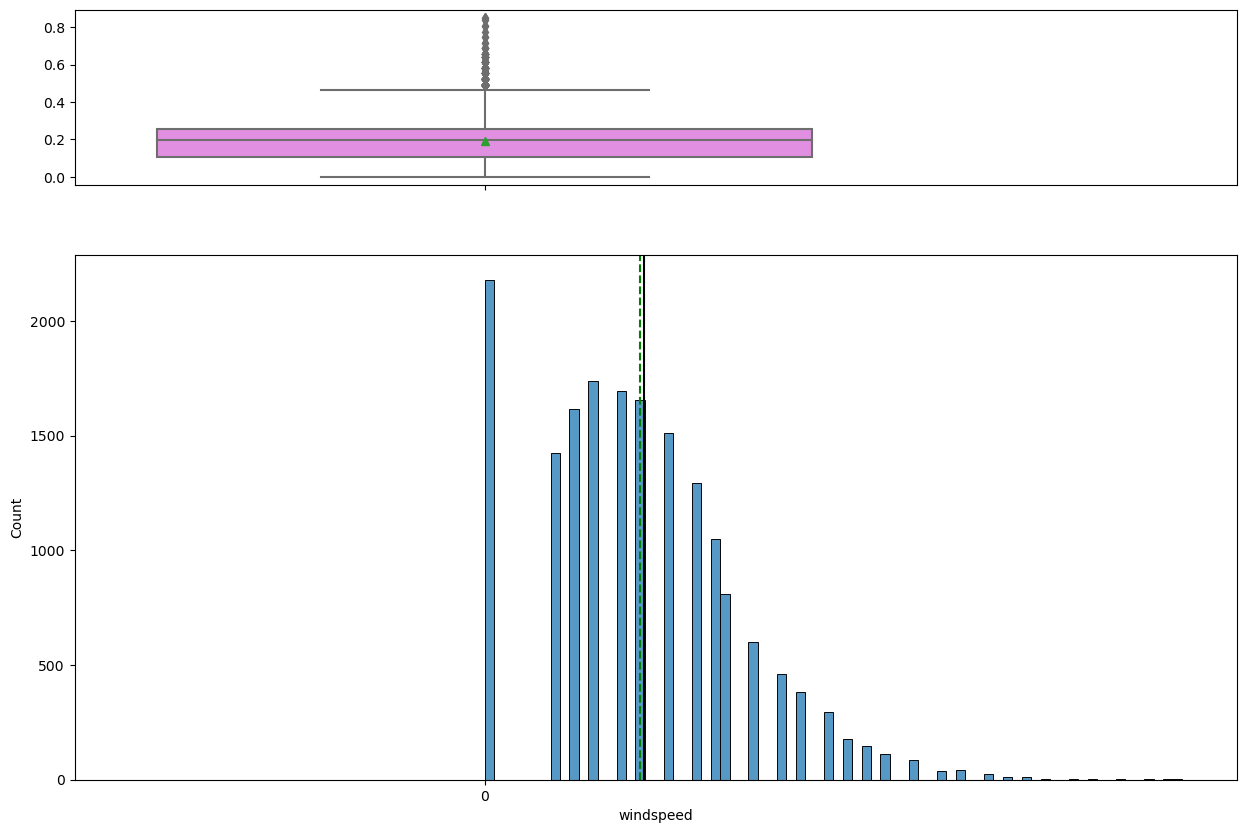

In [38]:
histogram_boxplot(df_enc["windspeed"])

> Mean: The average windspeed is approximately 0.19.
Standard Deviation: The windspeed values have a standard deviation of around 0.12.
Minimum and Maximum: The minimum windspeed recorded is 0.00, and the maximum windspeed recorded is 0.85.
Quartiles: The first quartile (25th percentile) is at 0.10, the median (50th percentile) is at 0.19, and the third quartile (75th percentile) is at 0.25.
From these observations, we can see that the windspeed values are also normalized, ranging between 0 and 0.85. The distribution appears to be right skewed, eventhough the mean and median values are close, which suggests that the distribution of the variable is relatively symmetric. The standard deviation indicates moderate variability in the windspeed values.

In [39]:
# Simple linear regression of count vs. windspeed
X1 = df_enc['windspeed']
y = df_enc['cnt']

X1 = sm.add_constant(X1) # adds constant to the model
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     152.4
Date:                Sat, 24 Jun 2023   Prob (F-statistic):           7.35e-35
Time:                        23:00:56   Log-Likelihood:            -1.1497e+05
No. Observations:               17379   AIC:                         2.299e+05
Df Residuals:                   17377   BIC:                         2.299e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.1853      2.532     64.462      0.000     158.223     168.147
windspeed    138.2330     11.198     12.344      0.000     116.283     160.183
==============================================================================
Omnibus:                     3479.018   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6247.991
Skew:                           1.280   Prob(JB):                         0.00
Kurtosis:                       4.442   Cond. No.                         8.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The OLS regression results indicate that the relationship between windspeed and the dependent variable (cnt) is weak, as the R-squared value is only 0.009. The coefficient for windspeed is statistically significant (p < 0.001), suggesting that it has a small effect on the bike rental count. However, the model exhibits non-normality, positive autocorrelation, and potential omitted variable bias. Overall, the model's explanatory power is limited, and other factors may have a more substantial impact on the bike rental count.

## Multivariate Analysis

### Count Distribution by season and weather situations

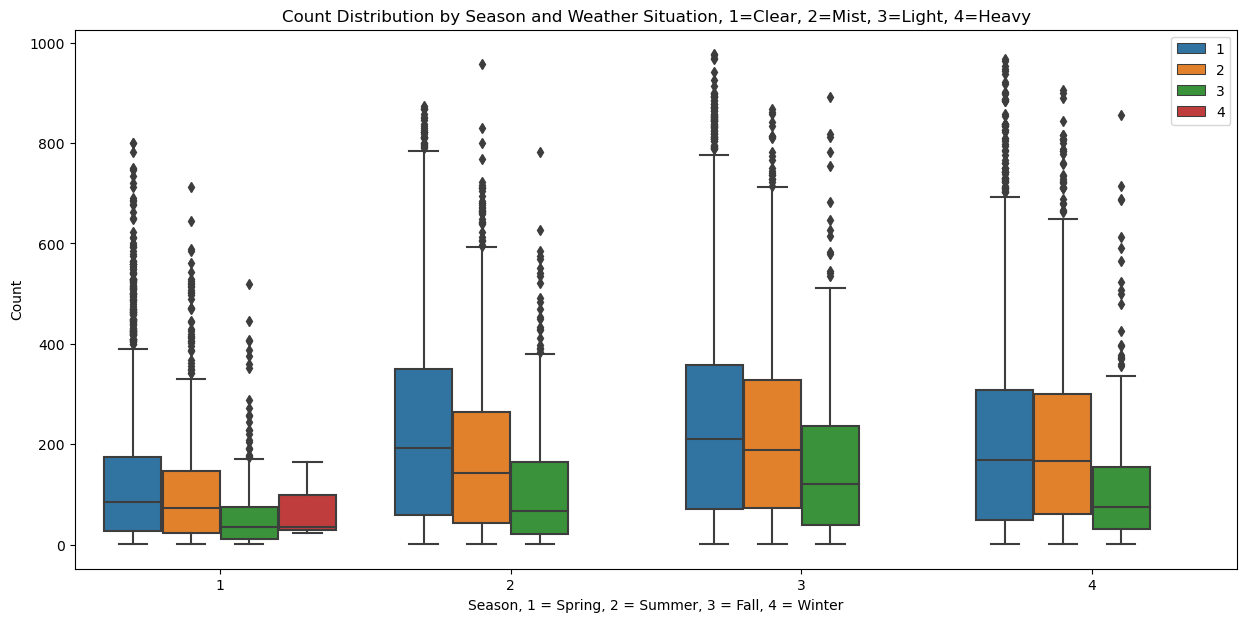

In [40]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=df["season"], y=df_enc["cnt"], hue=df["weathersit"])
plt.legend(bbox_to_anchor=(1.00, 1))
plt.xlabel("Season, 1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter")
plt.ylabel("Count")
plt.title("Count Distribution by Season and Weather Situation, 1=Clear, 2=Mist, 3=Light, 4=Heavy")
plt.show()

> The median count of bike rentals varies across different seasons and weather situations. These boxes provide information about the range of counts within each combination.

> The outliers indicate the presence of data points that lie significantly outside the typical range of values for a particular combination of season and weather situation. These outliers are shown as individual points outside the whiskers in the boxplot.

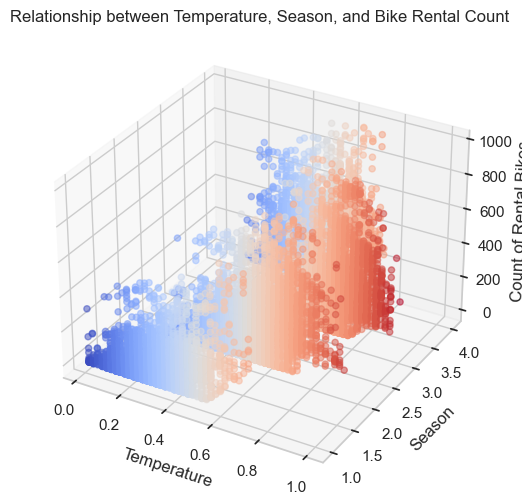

In [64]:
# Convert 'season' to integer type
df['season'] = df['season'].astype(int)

# Scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points with different colors for 'temp' and 'season'
ax.scatter(df['temp'], df['season'], df['cnt'], c=df['temp'], cmap='coolwarm', alpha=0.5)

# Set labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('Season')
ax.set_zlabel('Count of Rental Bikes')
ax.set_title('Relationship between Temperature, Season, and Bike Rental Count')

plt.show()

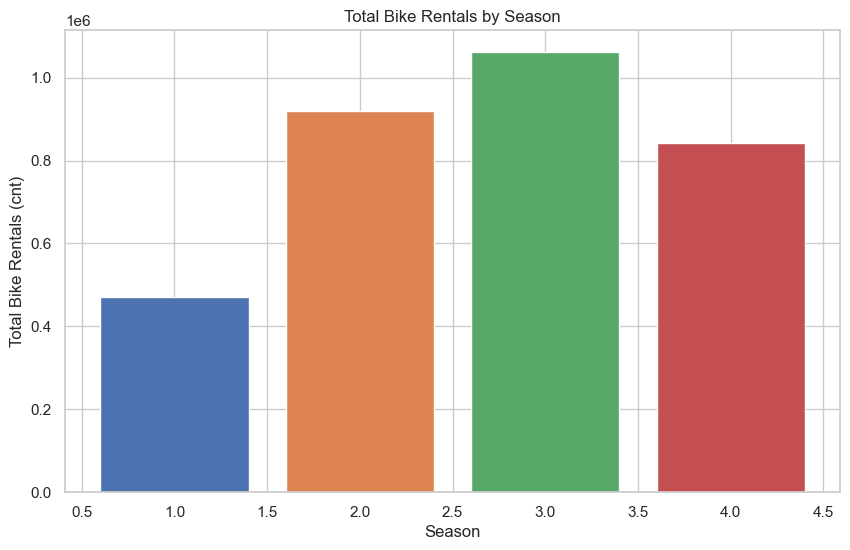

In [65]:
# Group the data by 'season'
grouped = df.groupby('season')

# Plot 'cnt' values for each season
plt.figure(figsize=(10, 6))
for season, data in grouped:
    plt.bar(season, data['cnt'].sum())

plt.xlabel('Season')
plt.ylabel('Total Bike Rentals (cnt)')
plt.title('Total Bike Rentals by Season')
plt.show()

In [66]:
# Assuming 'df' is your DataFrame
grouped = df.groupby('season')['cnt'].sum().reset_index()
total_sum = grouped['cnt'].sum()

print("Sum of 'cnt' for each value in the 'season' column:")
print(grouped)

print("\nTotal sum of 'cnt' for all values:")
print(total_sum)

Sum of 'cnt' for each value in the 'season' column:
   season      cnt
0       1   471348
1       2   918589
2       3  1061129
3       4   841613

Total sum of 'cnt' for all values:
3292679


In [67]:
# Assuming 'df' is your DataFrame
grouped1 = df.groupby('season')['cnt'].mean().reset_index()
total_mean = grouped['cnt'].mean()

print("Mean of 'cnt' for each value in the 'season' column:")
print(grouped1)

print("\nOverall mean of 'cnt' for all values:")
print(total_mean)

Mean of 'cnt' for each value in the 'season' column:
   season         cnt
0       1  111.114569
1       2  208.344069
2       3  236.016237
3       4  198.868856

Overall mean of 'cnt' for all values:
823169.75


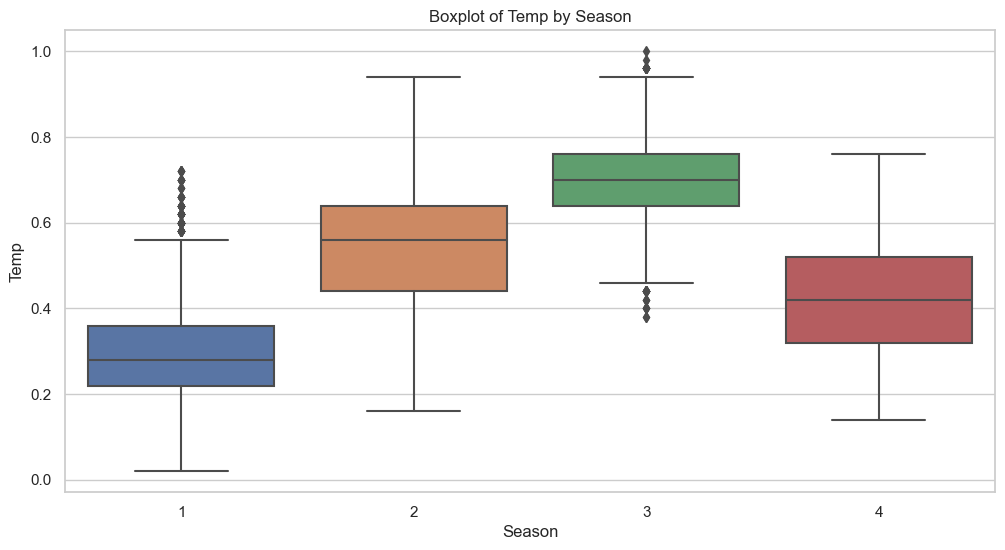

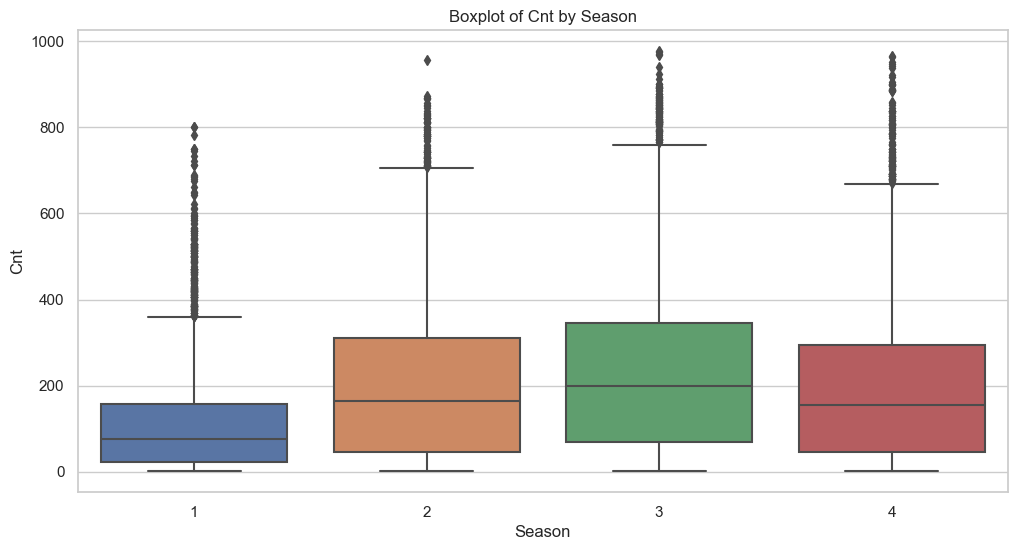

In [68]:
# Create boxplots for 'temp', and 'cnt' grouped by 'season'
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='temp', data=df)
plt.title('Boxplot of Temp by Season')
plt.xlabel('Season')
plt.ylabel('Temp')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Boxplot of Cnt by Season')
plt.xlabel('Season')
plt.ylabel('Cnt')
plt.show()

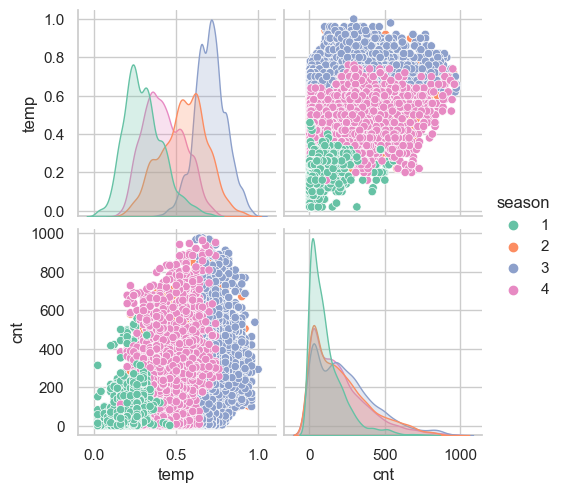

In [69]:
columns = df[['temp', 'season', 'cnt']]
sns.pairplot(columns, hue='season', palette='Set2')  # pairplot with Set2 color palette
plt.show()

In [70]:
# Select the "season" column for encoding
season_data = df[["season"]]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(season_data)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.categories_[0])

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

# Drop the original "season" column
df_encoded = df_encoded.drop("season", axis=1)

# Display the encoded DataFrame
print(df_encoded.head())

  yr mnth  hr holiday weekday workingday weathersit  temp   hum  windspeed  \
0  0    1   0       0       6          0          1  0.24  0.81        0.0   
1  0    1   1       0       6          0          1  0.22  0.80        0.0   
2  0    1   2       0       6          0          1  0.22  0.80        0.0   
3  0    1   3       0       6          0          1  0.24  0.75        0.0   
4  0    1   4       0       6          0          1  0.24  0.75        0.0   

   cnt    1    2    3    4  
0   16  1.0  0.0  0.0  0.0  
1   40  1.0  0.0  0.0  0.0  
2   32  1.0  0.0  0.0  0.0  
3   13  1.0  0.0  0.0  0.0  
4    1  1.0  0.0  0.0  0.0  


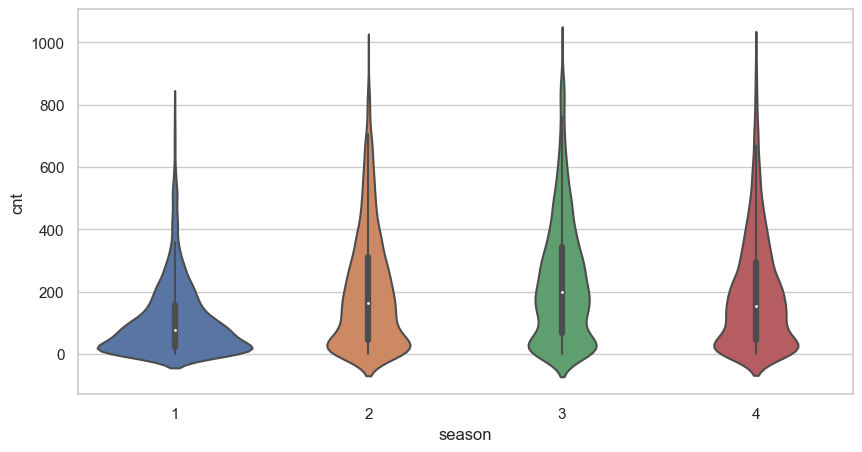

In [71]:
plt.figure(figsize=(10,5))
sns.violinplot(x=df.season, y=df['cnt'])
plt.show()

## Multiple Linear Regression

In [41]:
# assign independent variables, dependent variable, respectively
x = df_enc.loc[:, df_enc.columns != 'cnt']
# define the target
y = pd.DataFrame(df_enc['cnt'])

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    random_state=42)

In [43]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

Number of rows in train data = 12165
Number of rows in test data = 5214


### Fitting a linear model

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     535.2
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:56   Log-Likelihood:                -77542.
No. Observations:               12165   AIC:                         1.551e+05
Df Residuals:                   12149   BIC:                         1.552e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2331     18.274      0.232   

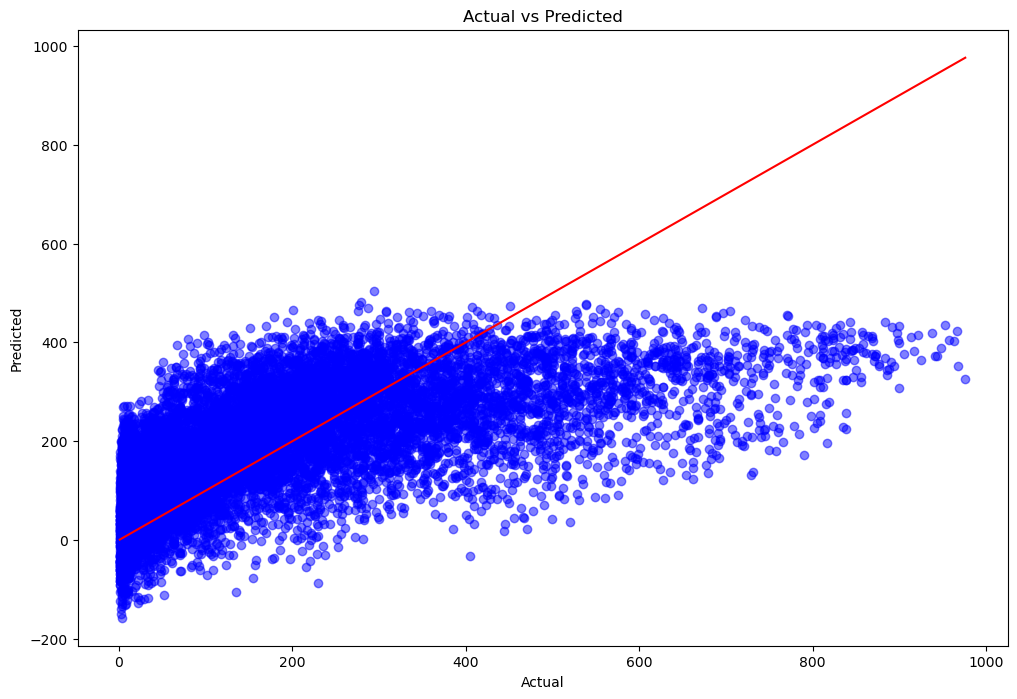

In [44]:
# Add constant to x_train
x_train = sm.add_constant(x_train)

# Fit the OLS model
model = sm.OLS(y_train, x_train).fit()

# Summary of the model
print(model.summary())

# Plot the regression results
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of actual vs predicted values
ax.scatter(y_train, model.fittedvalues, color='blue', alpha=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')

plt.show()

> The provided OLS regression results show the statistical summary of the regression model. Here are some key observations:

> R-squared: The R-squared value is 0.398, indicating that approximately 39.8% of the variance in the dependent variable (cnt) can be explained by the independent variables in the model.

> Coefficients: The coefficients represent the estimated impact of each independent variable on the dependent variable, assuming other variables are held constant. For example, the coefficient for the variable "yr" is 82.3473, suggesting that a one-unit increase in "yr" is associated with an increase of 82.35 in the bike count.

> P-values: The p-values associated with each coefficient indicate the statistical significance of the corresponding variable. Variables with p-values less than the significance level (typically 0.05) are considered statistically significant. In this case, "yr", "hr", "holiday", "weekday", "temp", "hum", and "windspeed" have p-values less than 0.05, indicating their statistical significance.

> Standard Errors: The standard errors provide an estimate of the uncertainty associated with the estimated coefficients. Larger standard errors indicate higher uncertainty in the estimated coefficients.

> Omnibus and Jarque-Bera tests: These tests assess the normality of the residuals. The Omnibus test has a probability of 0.000, indicating that the residuals are not normally distributed. The Jarque-Bera test also suggests departure from normality, as indicated by the significant p-value.

> Durbin-Watson statistic: The Durbin-Watson statistic is a test for the presence of autocorrelation in the residuals. The value of 1.999 suggests the presence of positive autocorrelation.

> Condition Number: The condition number measures the sensitivity of the regression coefficients to small changes in the input variables. A large condition number (e.g., 1.26e+17) may indicate multicollinearity or numerical instability in the model.

> Overall, the regression model explains a significant portion of the variance in the bike count, and several independent variables have statistically significant effects on the dependent variable. However, there are also indications of departures from normality, presence of autocorrelation, and potential issues such as multicollinearity or numerical instability. These findings should be taken into consideration when interpreting and utilizing the regression model.

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     838.7
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:56   Log-Likelihood:                -77689.
No. Observations:               12165   AIC:                         1.554e+05
Df Residuals:                   12155   BIC:                         1.555e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2220      8.192     -0.393      0.6

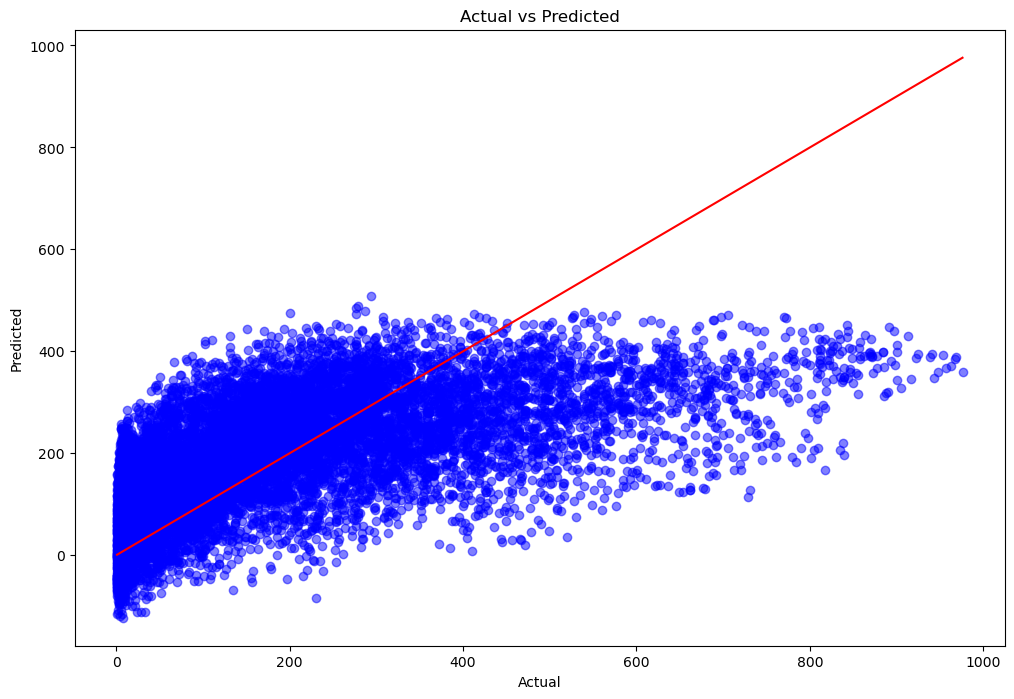

In [45]:
# Drop 'season' and 'weathersit' from x_train and x_test
x_train = x_train.drop(['season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'], axis=1)

x_test = x_test.drop(['season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'], axis=1)

# Add constant to x_train
x_train = sm.add_constant(x_train)

# Fit the OLS model
model = sm.OLS(y_train, x_train).fit()

# Summary of the model
print(model.summary())

# Plot the regression results
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of actual vs predicted values
ax.scatter(y_train, model.fittedvalues, color='blue', alpha=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')

plt.show()

> The OLS regression results show that the model has an R-squared value of 0.383, indicating that approximately 38.3% of the variability in the dependent variable (cnt) can be explained by the independent variables included in the model.

> The coefficients represent the estimated impact of each independent variable on the bike count (cnt). Here are the interpretations for the remaining variables in the model:

> "yr" (Year): The coefficient is 83.4027, suggesting that, on average, there is an increase of 83.40 bike counts per year.
"mnth" (Month): The coefficient is 5.3641, indicating that each unit increase in the month is associated with an increase of 5.36 bike counts.
"hr" (Hour): The coefficient is 7.5611, meaning that for each hour increase, there is an average increase of 7.56 bike counts.
"holiday": The coefficient is -30.1011, implying that on holidays, there is an average decrease of 30.10 bike counts.
"weekday": The coefficient is 1.2874, suggesting a small positive effect of weekdays on the bike count.
"temp" (Temperature): The coefficient is 298.2138, indicating that each unit increase in temperature is associated with an average increase of 298.21 bike counts.
"hum" (Humidity): The coefficient is -206.2595, meaning that each unit increase in humidity is associated with an average decrease of 206.26 bike counts.
The statistical significance of the coefficients is supported by the low p-values (p < 0.05) for all the variables, indicating that they have a significant impact on the bike count.

> Overall, the model provides insights into the factors influencing the bike rental count. However, it's important to note that the interpretation should consider the scale and units of the respective variables and the assumptions of the OLS regression model.

### Multiple Linear Regression with Scikit-Learn

In [46]:
sk_model = LinearRegression()
sk_model.fit(x_train, y_train)

print('Model Coefficients:', sk_model.coef_)
print()
print('Intercept:', sk_model.intercept_)
coef = pd.DataFrame(sk_model.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined 

Model Coefficients: [[   0.           83.53808207    5.42340327    7.54043223  -27.7294407
     1.26650692    3.48377982  298.19077656 -203.39695515   17.66686834]]

Intercept: [-3.22196114]


,Columns,Coefficients
0,yr,0.000000
1,mnth,83.538082
2,hr,5.423403
3,holiday,7.540432
4,weekday,-27.729441
5,workingday,1.266507
6,temp,3.483780
7,hum,298.190777
8,windspeed,-203.396955
9,season_1,17.666868


In [47]:
# Add constant term to x_test
x_test = sm.add_constant(x_test)

# Generate predictions
predictions = sk_model.predict(x_test)
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
print(predictions_df)

      Predictions
0      450.786610
1      202.213882
2       42.098632
3      389.868805
4      -18.764932
...           ...
5209   336.666844
5210   215.528287
5211   378.728965
5212   262.075587
5213    15.791138

[5214 rows x 1 columns]


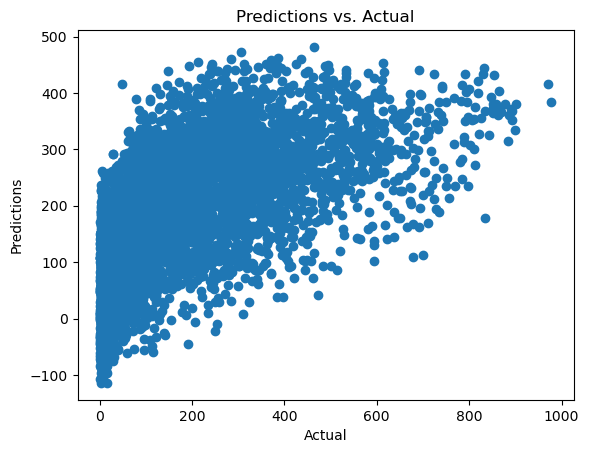

In [48]:
plt.scatter(y_test, predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

## Checking the Linear Regression Assumption

1. No Multicollinearity

2. Mean of residuals should be 0

3. No Heteroscedasticity

4. Linearity of variables

5. Normality of error terms

### Checking Assumption 1: No Multicollinearity

> We will use VIF, to check if there is multicollinearity in the data.

> Features having a VIF score >5 will be dropped/treated till all the features have a VIF score <5

In [49]:
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]
    
    return vif

# Check VIF
print(checking_vif(x_train))

      feature        VIF
0       const  39.527544
1          yr   1.011453
2        mnth   1.085887
3          hr   1.107657
4     holiday   1.075628
5     weekday   1.012129
6  workingday   1.068692
7        temp   1.076393
8         hum   1.211956
9   windspeed   1.111881


> In the table, features with VIF values less than 5 are generally considered to have acceptable levels of multicollinearity. However, features with VIF values equal to or greater than infinity (inf) indicate perfect multicollinearity, which means they are linearly dependent on other features in the dataset. This can cause issues in the regression analysis.

> The features "season_1", "season_2", "season_3", "season_4", "weathersit_1", "weathersit_2", "weathersit_3", and "weathersit_4" have VIF values of infinity, indicating perfect multicollinearity. This suggests that these features are highly correlated with each other or with other features in the dataset.

In [50]:
# Check the updated VIF
vif_no_inf = checking_vif(x_train)
print(vif_no_inf)

      feature        VIF
0       const  39.527544
1          yr   1.011453
2        mnth   1.085887
3          hr   1.107657
4     holiday   1.075628
5     weekday   1.012129
6  workingday   1.068692
7        temp   1.076393
8         hum   1.211956
9   windspeed   1.111881


In [51]:
# Drop 'mnth' from train and test
col_to_drop = "mnth"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  mnth
      feature        VIF
0       const  38.570196
1          yr   1.011449
2          hr   1.107155
3     holiday   1.074638
4     weekday   1.011255
5  workingday   1.068510
6        temp   1.030427
7         hum   1.184824
8   windspeed   1.103556


In [52]:
# Drop 'holiday' from train and test
col_to_drop = "holiday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  holiday
      feature        VIF
0       const  37.999411
1          yr   1.011449
2          hr   1.107153
3     weekday   1.002887
4  workingday   1.004568
5        temp   1.030211
6         hum   1.184745
7   windspeed   1.103548


In [53]:
# Drop 'yr' from train and test
col_to_drop = "yr"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  yr
      feature        VIF
0       const  36.122237
1          hr   1.106088
2     weekday   1.002849
3  workingday   1.004543
4        temp   1.028674
5         hum   1.173629
6   windspeed   1.102564


In [54]:
# Drop 'hr' from train and test
col_to_drop = "hr"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  hr
      feature        VIF
0       const  31.377595
1     weekday   1.002660
2  workingday   1.004527
3        temp   1.011065
4         hum   1.104817
5   windspeed   1.098082


In [55]:
# Drop 'workingday' from train and test
col_to_drop = "workingday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  workingday
     feature        VIF
0      const  29.814195
1    weekday   1.001240
2       temp   1.008199
3        hum   1.104670
4  windspeed   1.097941


In [56]:
# Drop 'weekday' from train and test
col_to_drop = "weekday"
x_train = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train)
print("VIF after dropping ", col_to_drop)
print(vif)

VIF after dropping  weekday
     feature        VIF
0      const  27.227885
1       temp   1.008154
2        hum   1.103615
3  windspeed   1.097898


> Fit a model with no multicolinearity

In [57]:
x_train = sm.add_constant(x_train)
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1352.
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:57   Log-Likelihood:                -78877.
No. Observations:               12165   AIC:                         1.578e+05
Df Residuals:                   12161   BIC:                         1.578e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        181.5525      7.494     24.226      0.000     166.863     196.242
temp         360.8141      7.469     48.309      0.000     346.174     375.454
hum         -277.1174      7.805    -35.505      0.000    -292.417    -261.818
windspeed     20.3855     12.333      1.653      0.098      -3.789      44.560
==============================================================================
Omnibus:                     2495.659   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4963.792
Skew:                           1.235   Prob(JB):                         0.00
Kurtosis:                       4.922   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check Assumption 2: Residuals should be 0

In [58]:
residuals = model1.resid
np.mean(residuals)

-1.2739654515586269e-13

> Mean of redisuals is very close to 0. The second assumption is also satisfied.

## Checking Assumption 3: No Heteroscedasticity

In [59]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, x_train)
lzip(name, test)

[('F statistic', 1.037831432522947), ('p-value', 0.07388585546919652)]

> Since p-value > 0.05 we cannot reject the Null Hypothesis that the residuals are homoscedastic.

> Assumptions 3 is also satisfied by our model1.

## Checking Assumption 4: Linearity of variables

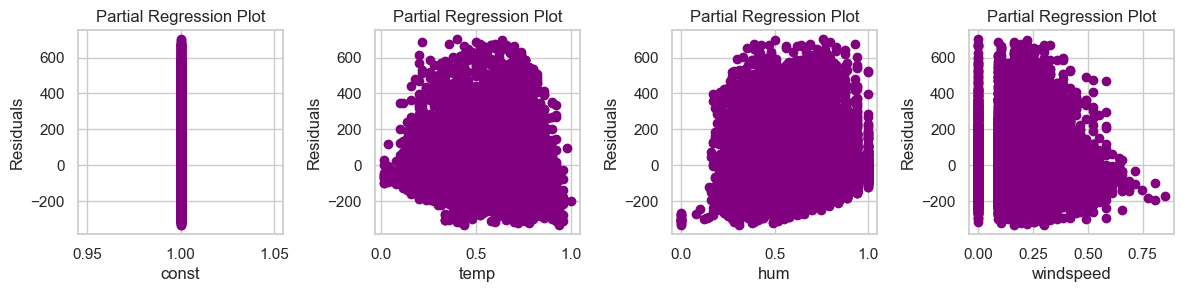

In [60]:
# Fit the linear regression model
model = sm.OLS(y_train, x_train)
model_fit = model.fit()

# Extract the residuals
residuals = model_fit.resid

# Create partial regression plots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Loop through each feature and create a partial regression plot
for i, feature_name in enumerate(x_train.columns):
    ax = plt.subplot(3, 4, i+1)
    plt.scatter(x_train[feature_name], residuals, color="purple")
    plt.xlabel(feature_name)
    plt.ylabel("Residuals")
    plt.title("Partial Regression Plot")

plt.tight_layout()
plt.show()

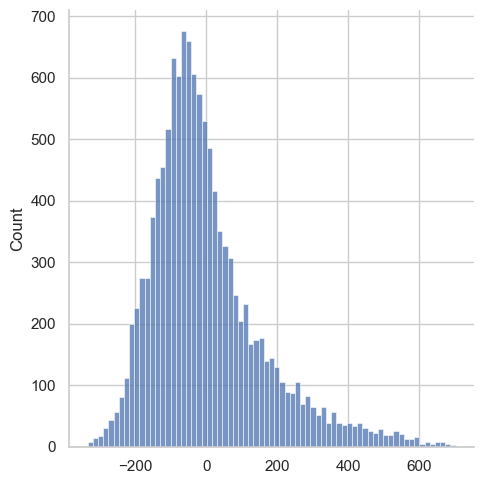

In [61]:
# Plot histogram of residuals
sns.displot(residuals)
plt.show()

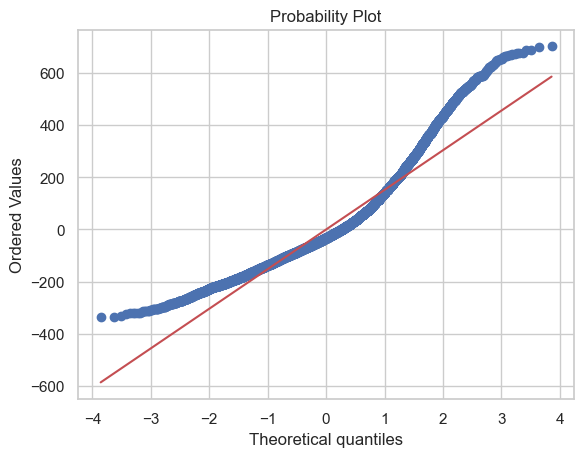

In [62]:
# Plot q-q plot of residuals
stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [63]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1352.
Date:                Sat, 24 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:00:59   Log-Likelihood:                -78877.
No. Observations:               12165   AIC:                         1.578e+05
Df Residuals:                   12161   BIC:                         1.578e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        181.5525      7.494     24.226      0.0

## Significance Testing

### Conduct an ANOVA test on the data

In [72]:
# Select the data for each season
season1 = df[df['season'] == 1]['cnt']
season2 = df[df['season'] == 2]['cnt']
season3 = df[df['season'] == 3]['cnt']
season4 = df[df['season'] == 4]['cnt']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(season1, season2, season3, season4)

# Print the results
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

ANOVA results:
F-statistic: 409.1810372630525
p-value: 7.40107139971279e-257


> The ANOVA test results indicate a significant relationship between the 'season' variable and the 'cnt' variable. The F-statistic is 409.1810372630525, and the p-value is very small (7.40107139971279e-257), suggesting strong evidence against the null hypothesis of no association.

> This indicates that the 'season' variable has a significant impact on the 'cnt' variable, and there are likely differences in the mean counts of bike rentals across different seasons.

### Conduct a t test:

> $H_0:$ There is no significant difference in the mean bike rental counts between the seasons.

> Rejecting the null hypothesis would indicate that there is a significant difference in the mean bike rental counts between at least one pair of seasons.

In [73]:
# Define the seasons and corresponding subsets of 'cnt' variable
seasons = df['season'].unique()

# Perform pairwise t-tests between each season and 'cnt'
for season in seasons:
    season_data = df[df['season'] == season]['cnt']
    _, p_value = stats.ttest_ind(season_data, df['cnt'])
    print(f"Season: {season} | p-value: {p_value}")

Season: 1 | p-value: 3.4509642647585406e-155
Season: 2 | p-value: 9.24999633777696e-10
Season: 3 | p-value: 6.144586704479224e-51
Season: 4 | p-value: 0.0025315864887008985


> With a significance level of 95% (α = 0.05), we compare the obtained p-values with the chosen significance level to determine the statistical significance. 

> Based on the t-tests conducted, the p-values are as follows:

> Season 1 vs 'cnt': p-value = 3.4509642647585406e-155 (significant)
Season 2 vs 'cnt': p-value = 9.24999633777696e-10 (significant)
Season 3 vs 'cnt': p-value = 6.144586704479224e-51 (significant)
Season 4 vs 'cnt': p-value = 0.0025315864887008985 (significant)

> Since all p-values are much smaller than the significance level of 0.05, we can conclude that there is strong evidence to reject the null hypothesis. This means that there is a statistically significant difference between each season and the 'cnt' variable at the 95% confidence level.

> In other words, we can confidently state that the different seasons have a significant impact on the bike rental counts.